In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype('float32') / 255
print(mnist_digits.shape)

11501568/11490434 [==============================] - 0s 0us/step
(70000, 28, 28, 1)


In [3]:
input_img = (28, 28, 1)
latent_dim = 2

inputs = tf.keras.Input(shape=input_img)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', strides=2, padding='same')(inputs)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Flatten()(x)
z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_sigma = tf.keras.layers.Dense(latent_dim)(x)

class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
      z_mean, z_log_sigma = inputs
      epsilon = keras.backend.random_normal(shape=(keras.backend.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
      return z_mean + keras.backend.exp(z_log_sigma) * epsilon

z = Sampling()([z_mean, z_log_sigma])
encoder = tf.keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

latent_inputs = tf.keras.Input(shape=(latent_dim,), name='z_sampling')
x = tf.keras.layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = tf.keras.layers.Reshape((7, 7, 64))(x)
x = tf.keras.layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same')(x)
outputs = tf.keras.layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])

vae = tf.keras.Model(inputs, outputs, name='vae')

reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, outputs), axis=(1, 2)))
kl_loss = 1 + z_log_sigma - keras.backend.square(z_mean) - keras.backend.exp(z_log_sigma)
kl_loss = keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = keras.backend.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

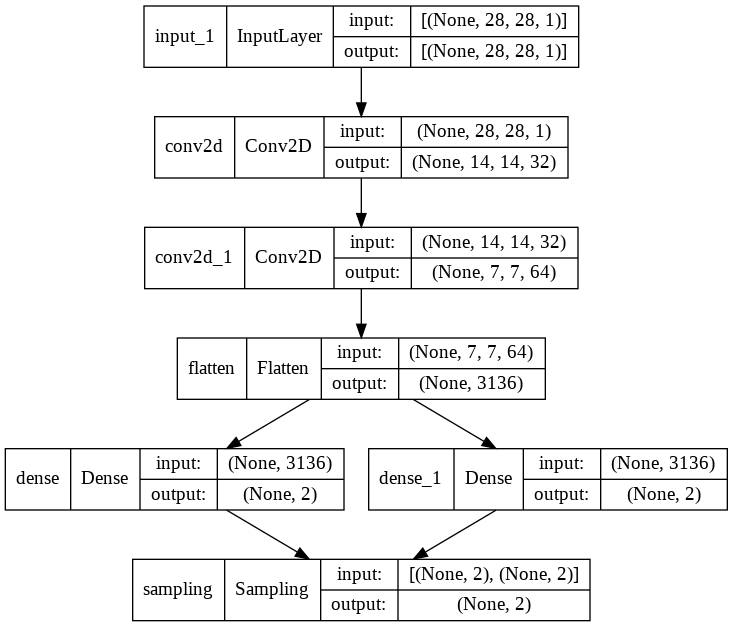

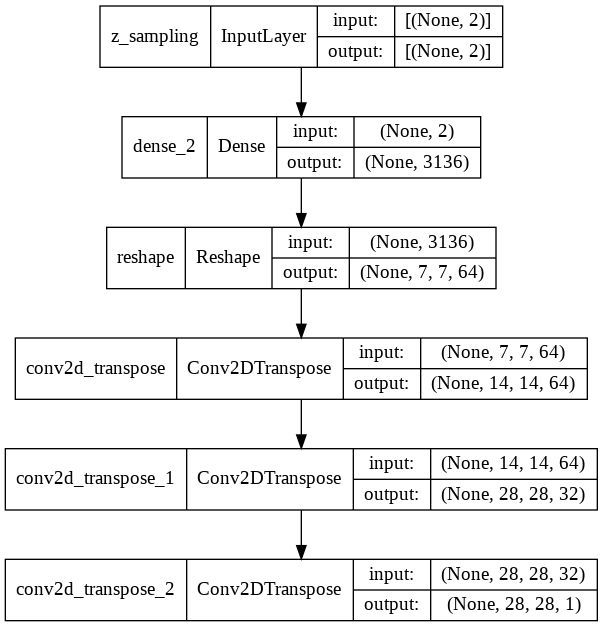

In [4]:
print(encoder.summary(), decoder.summary())
display(tf.keras.utils.plot_model(encoder, show_shapes=True))
display(tf.keras.utils.plot_model(decoder, show_shapes=True))

In [5]:
def plot_latent_space(n=30):
    digit_size = input_img[0]
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(15, 15))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [6]:
class Visualizer(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    plot_latent_space()
visualizer = Visualizer()

Epoch 1/5
547/547 [==============================] - ETA: 0s - loss: 192.2881

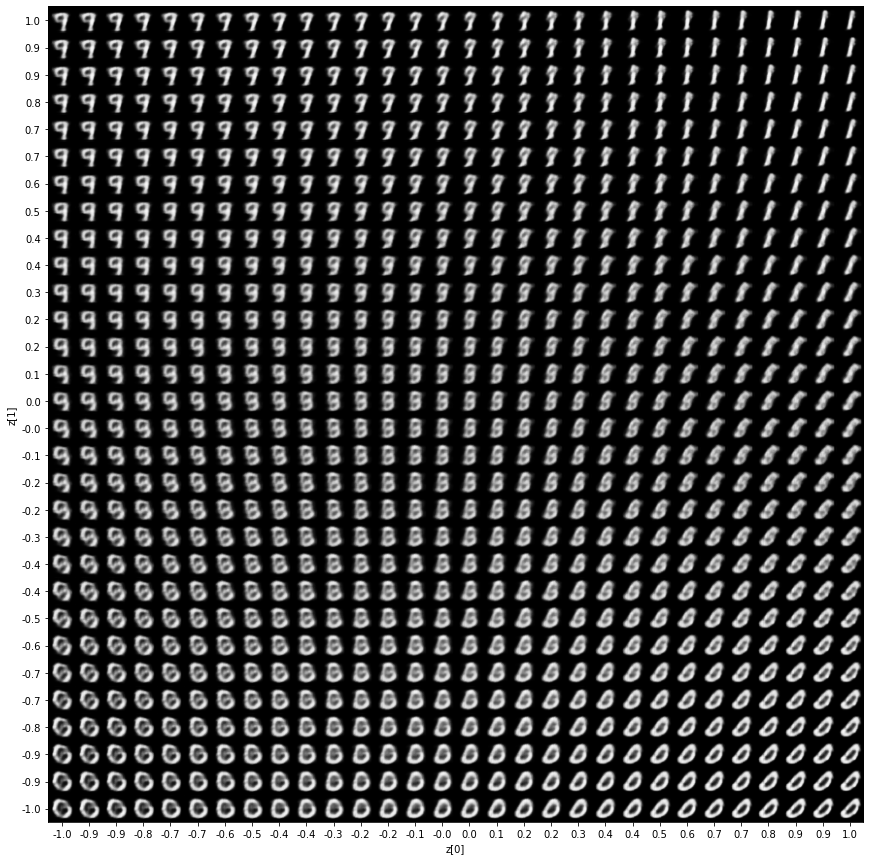

547/547 [==============================] - 156s 281ms/step - loss: 192.2881
Epoch 2/5
547/547 [==============================] - ETA: 0s - loss: 159.5183

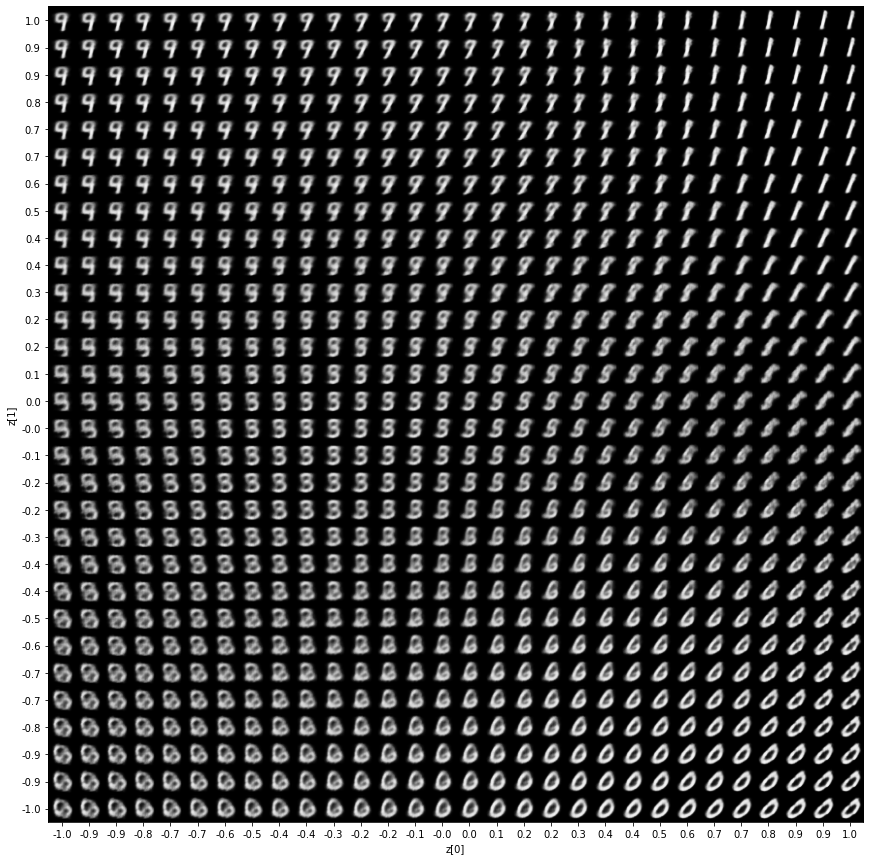

547/547 [==============================] - 149s 272ms/step - loss: 159.5183
Epoch 3/5
547/547 [==============================] - ETA: 0s - loss: 154.7662

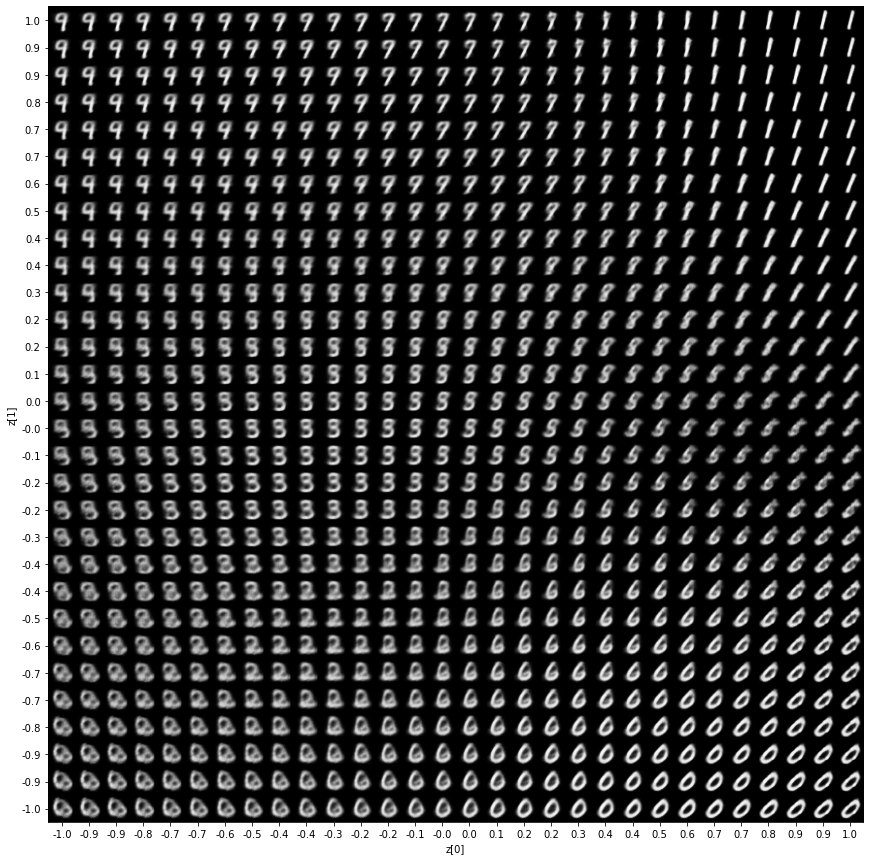

547/547 [==============================] - 152s 278ms/step - loss: 154.7662
Epoch 4/5
547/547 [==============================] - ETA: 0s - loss: 152.6130

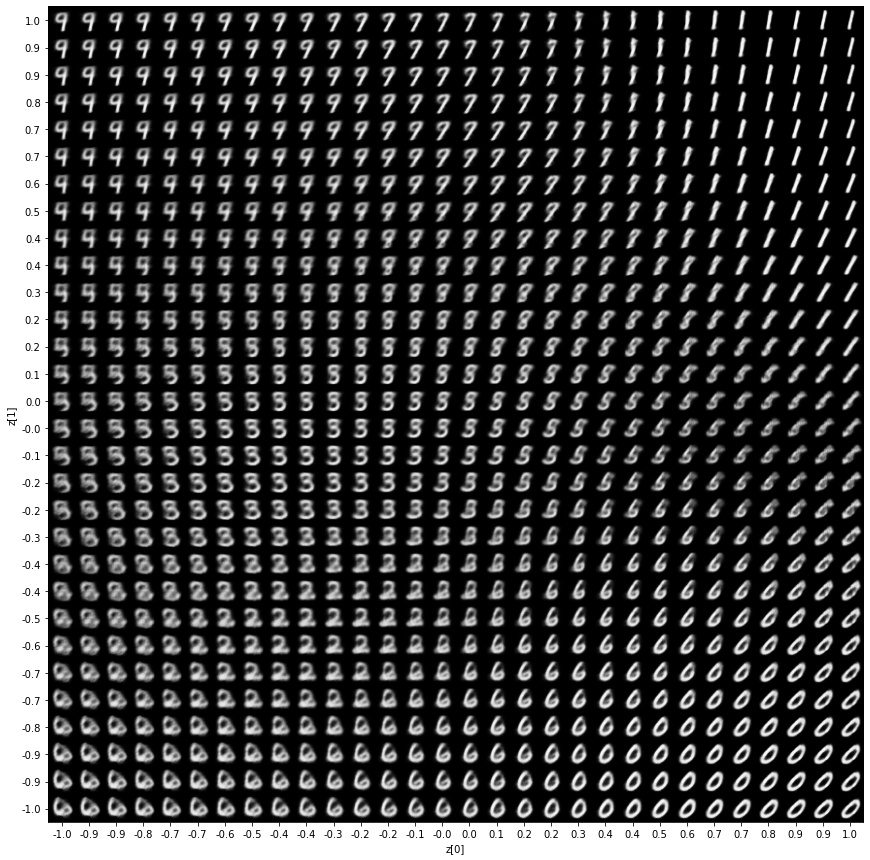

547/547 [==============================] - 155s 284ms/step - loss: 152.6130
Epoch 5/5
547/547 [==============================] - ETA: 0s - loss: 151.1931

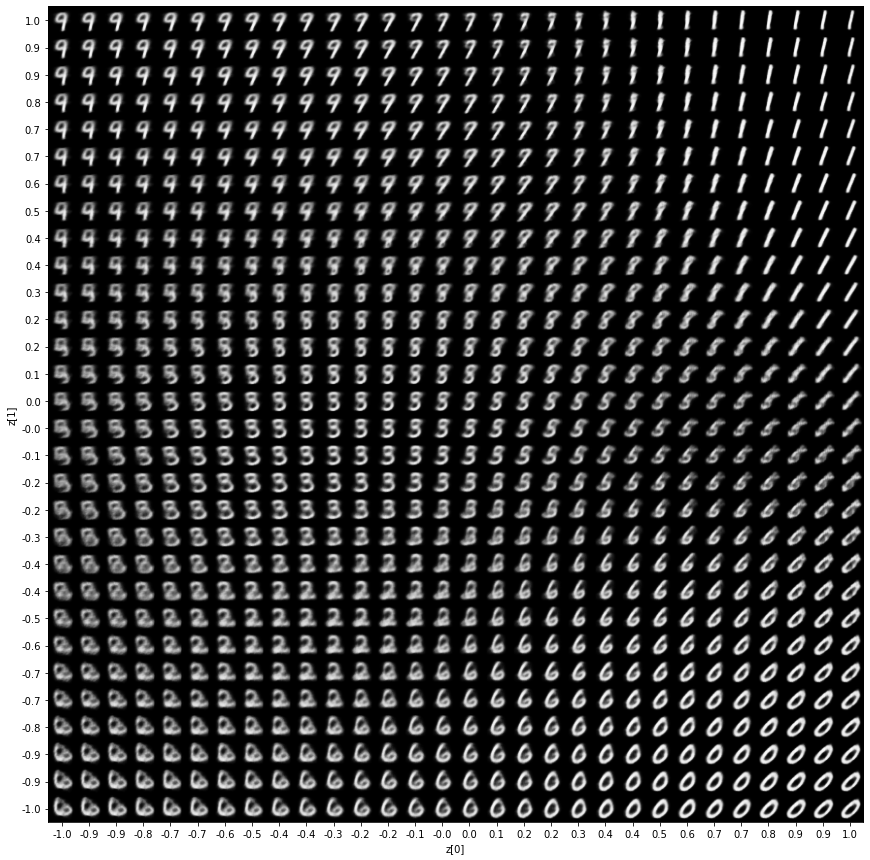

547/547 [==============================] - 159s 291ms/step - loss: 151.1931


In [7]:
vae.fit(mnist_digits, epochs=5, batch_size=128, callbacks=[visualizer])